In [1]:
import os
import pickle
import numpy as np

In [2]:
dataset_path = "WESAD"

In [3]:
subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

In [4]:
def load_subject_data(subject_id):
    subject_file = os.path.join(dataset_path, f'{subject_id}/{subject_id}.pkl')
    
    with open(subject_file, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    
    return data

In [5]:
# Load data for all subjects
all_subjects_data = {subject: load_subject_data(subject) for subject in subjects}

In [6]:
import numpy as np
from scipy import signal

target_freq = 4  # Hz

freq_acc = 32  # Accelerometer frequency (Hz)
freq_bvp = 64  # BVP frequency (Hz)
freq_eda_temp = 4  # EDA and Temperature frequency (Hz)
freq_labels = 700  # Frequency of labels (adjust if needed based on actual data)

def resample_labels_aggregation(original_labels, freq_labels, new_length, method='majority'):
    window_size = len(original_labels) // new_length
    resampled_labels = []
    
    for i in range(new_length):
        window_start = i * window_size
        window_end = window_start + window_size
        window_labels = original_labels[window_start:window_end]
        
        if method == 'majority':
            resampled_labels.append(np.bincount(window_labels).argmax())
        elif method == 'mixed':
            unique, counts = np.unique(window_labels, return_counts=True)
            if len(counts) > 1 and counts.max() < window_size * 0.6:
                resampled_labels.append(-1)
            else:
                resampled_labels.append(np.bincount(window_labels).argmax())
    
    return np.array(resampled_labels)

resampled_data_all_subjects = {}

for subject, data in all_subjects_data.items():
    wrist_acc = data['signal']['wrist']['ACC']
    wrist_bvp = data['signal']['wrist']['BVP']
    wrist_eda = data['signal']['wrist']['EDA']
    wrist_temp = data['signal']['wrist']['TEMP']
    labels = data['label']

    time_acc = np.arange(wrist_acc.shape[0]) / freq_acc
    time_bvp = np.arange(wrist_bvp.shape[0]) / freq_bvp
    time_eda_temp = np.arange(wrist_eda.shape[0]) / freq_eda_temp
    time_labels = np.arange(len(labels)) / freq_labels

    new_time = np.arange(0, time_acc[-1], 1 / target_freq)
    new_length = len(new_time)

    wrist_acc_resampled = np.array([np.interp(new_time, time_acc, wrist_acc[:, i]) for i in range(3)]).T
    wrist_bvp_resampled = np.interp(new_time, time_bvp, wrist_bvp[:, 0])
    wrist_eda_resampled = np.interp(new_time, time_eda_temp, wrist_eda[:, 0])
    wrist_temp_resampled = np.interp(new_time, time_eda_temp, wrist_temp[:, 0])

    filtered_labels = labels[np.isin(labels, [1, 2, 3, 4])]
    resampled_labels = resample_labels_aggregation(filtered_labels, freq_labels, new_length, method='majority')

    if len(resampled_labels) > len(new_time):
        resampled_labels = resampled_labels[:len(new_time)]
    elif len(resampled_labels) < len(new_time):
        new_time = new_time[:len(resampled_labels)]

    resampled_data_all_subjects[subject] = {
        'ACC': wrist_acc_resampled[:len(new_time)],
        'BVP': wrist_bvp_resampled[:len(new_time)],
        'EDA': wrist_eda_resampled[:len(new_time)],
        'TEMP': wrist_temp_resampled[:len(new_time)],
        'Labels': resampled_labels
    }

    print(f"Subject {subject}:")
    print(f"  Resampled wrist ACC shape: {wrist_acc_resampled.shape}")
    print(f"  Resampled wrist BVP shape: {wrist_bvp_resampled.shape}")
    print(f"  Resampled wrist EDA shape: {wrist_eda_resampled.shape}")
    print(f"  Resampled wrist TEMP shape: {wrist_temp_resampled.shape}")
    print(f"  Resampled labels shape: {resampled_labels.shape}")
    unique_labels, counts_labels = np.unique(resampled_labels, return_counts=True)
    print(f"  Label distribution after resampling: {dict(zip(unique_labels, counts_labels))}\n")


Subject S2:
  Resampled wrist ACC shape: (24316, 3)
  Resampled wrist BVP shape: (24316,)
  Resampled wrist EDA shape: (24316,)
  Resampled wrist TEMP shape: (24316,)
  Resampled labels shape: (24316,)
  Label distribution after resampling: {1: 9648, 2: 5187, 3: 3053, 4: 6428}

Subject S3:
  Resampled wrist ACC shape: (25972, 3)
  Resampled wrist BVP shape: (25972,)
  Resampled wrist EDA shape: (25972,)
  Resampled wrist TEMP shape: (25972,)
  Resampled labels shape: (25972,)
  Label distribution after resampling: {1: 10101, 2: 5671, 3: 3323, 4: 6877}

Subject S4:
  Resampled wrist ACC shape: (25692, 3)
  Resampled wrist BVP shape: (25692,)
  Resampled wrist EDA shape: (25692,)
  Resampled wrist TEMP shape: (25692,)
  Resampled labels shape: (25692,)
  Label distribution after resampling: {1: 10133, 2: 5556, 3: 3255, 4: 6748}

Subject S5:
  Resampled wrist ACC shape: (25032, 3)
  Resampled wrist BVP shape: (25032,)
  Resampled wrist EDA shape: (25032,)
  Resampled wrist TEMP shape: (25

In [7]:
from sklearn.utils import resample

# Function to merge labels for binary classification (stress vs. non-stress)
def merge_labels(labels):
    merged_labels = np.copy(labels)
    merged_labels[labels == 1] = 0  # Baseline -> non-stress (0)
    merged_labels[labels == 3] = 0  # Amusement -> non-stress (0)
    merged_labels[labels == 4] = 0  # Meditation -> non-stress (0)
    merged_labels[labels == 2] = 1  # Stress -> stress (1)
    return merged_labels

# Function to balance the dataset by downsampling the larger class
def balance_classes(data, labels):
    # Find the number of samples for each class
    stress_indices = np.where(labels == 1)[0]  # Stress class
    non_stress_indices = np.where(labels == 0)[0]  # Non-stress class

    # Determine the minority class size (to balance classes)
    n_samples = min(len(stress_indices), len(non_stress_indices))

    # Downsample both classes to have the same number of samples
    stress_downsampled = resample(stress_indices, n_samples=n_samples, random_state=42)
    non_stress_downsampled = resample(non_stress_indices, n_samples=n_samples, random_state=42)

    # Combine the balanced indices
    balanced_indices = np.concatenate([stress_downsampled, non_stress_downsampled])
    np.random.shuffle(balanced_indices)  # Shuffle the indices

    # Return balanced data and labels
    return data[balanced_indices], labels[balanced_indices]

# Store merged and balanced data for all subjects
balanced_data_all_subjects = {}

# Loop over each subject, merge labels, and balance the classes
for subject, data in resampled_data_all_subjects.items():
    # Extract wrist data and labels for the current subject
    wrist_acc = data['ACC']  # Resampled Accelerometer data
    wrist_bvp = data['BVP']  # Resampled BVP data
    wrist_eda = data['EDA']  # Resampled EDA data
    wrist_temp = data['TEMP']  # Resampled Temperature data
    labels = data['Labels']  # Resampled labels

    # Merge labels for binary classification
    merged_labels = merge_labels(labels)

    # Combine all wrist data into a single array (e.g., for feature extraction)
    combined_wrist_data = np.column_stack((wrist_acc, wrist_bvp, wrist_eda, wrist_temp))

    # Balance the dataset (equal stress and non-stress samples)
    balanced_wrist_data, balanced_labels = balance_classes(combined_wrist_data, merged_labels)

    # Store the balanced data and labels for the current subject
    balanced_data_all_subjects[subject] = {
        'WristData': balanced_wrist_data,
        'Labels': balanced_labels
    }

    # Debugging: Print shapes and label distribution after balancing
    print(f"Subject {subject}:")
    print(f"  Balanced wrist data shape: {balanced_wrist_data.shape}")
    print(f"  Balanced labels shape: {balanced_labels.shape}")
    unique_balanced_labels, counts_balanced_labels = np.unique(balanced_labels, return_counts=True)
    print(f"  Label distribution after balancing: {dict(zip(unique_balanced_labels, counts_balanced_labels))}\n")


Subject S2:
  Balanced wrist data shape: (10374, 6)
  Balanced labels shape: (10374,)
  Label distribution after balancing: {0: 5187, 1: 5187}

Subject S3:
  Balanced wrist data shape: (11342, 6)
  Balanced labels shape: (11342,)
  Label distribution after balancing: {0: 5671, 1: 5671}

Subject S4:
  Balanced wrist data shape: (11112, 6)
  Balanced labels shape: (11112,)
  Label distribution after balancing: {0: 5556, 1: 5556}

Subject S5:
  Balanced wrist data shape: (10750, 6)
  Balanced labels shape: (10750,)
  Label distribution after balancing: {0: 5375, 1: 5375}

Subject S6:
  Balanced wrist data shape: (12466, 6)
  Balanced labels shape: (12466,)
  Label distribution after balancing: {0: 6233, 1: 6233}

Subject S7:
  Balanced wrist data shape: (9050, 6)
  Balanced labels shape: (9050,)
  Label distribution after balancing: {0: 4525, 1: 4525}

Subject S8:
  Balanced wrist data shape: (9770, 6)
  Balanced labels shape: (9770,)
  Label distribution after balancing: {0: 4885, 1: 488

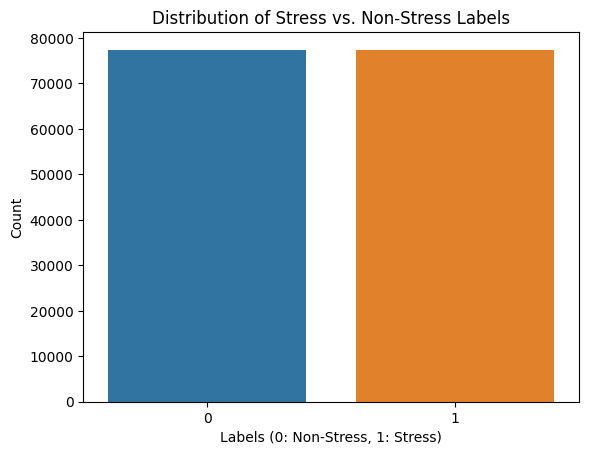

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check label distribution after balancing for all subjects
all_labels = []

for subject, data in balanced_data_all_subjects.items():
    labels = data['Labels']
    all_labels.extend(labels)

# Plot distribution of labels
sns.countplot(x=all_labels)
plt.title('Distribution of Stress vs. Non-Stress Labels')
plt.xlabel('Labels (0: Non-Stress, 1: Stress)')
plt.ylabel('Count')
plt.show()


In [9]:
# Function to compute basic statistics for a subject's data
def compute_statistics(data):
    stats = {
        'mean': np.mean(data, axis=0),
        'std': np.std(data, axis=0),
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

# Compute statistics for each subject's wrist data
for subject, data in balanced_data_all_subjects.items():
    print(f"Subject {subject}:")
    wrist_data = data['WristData']
    
    stats = compute_statistics(wrist_data)
    print(f"  Mean: {stats['mean']}")
    print(f"  Std: {stats['std']}")
    print(f"  Min: {stats['min']}")
    print(f"  Max: {stats['max']}")
    print("\n")


Subject S2:
  Mean: [34.8879892  -5.40871409 20.6454598  -0.35434452  0.49631999 33.85874012]
  Std: [19.79388159 37.88546895 23.5531918  81.2751401   0.34824488  1.11958437]
  Min: [-8.5000e+01 -1.0400e+02 -1.2800e+02 -7.3127e+02  4.5113e-02  3.2310e+01]
  Max: [127.       67.       95.      580.88      1.66104  35.97   ]


Subject S3:
  Mean: [-45.38934932   5.54584729  13.28663375   0.40269353   1.25275157
  31.71223946]
  Std: [15.60037729 30.78540988 27.4970625  29.10293045  1.45466078  0.79992307]
  Min: [-1.11000e+02 -6.00000e+01 -6.50000e+01 -4.04980e+02  2.92393e-01
  3.03500e+01]
  Max: [ 38.       114.        89.       357.94       8.792326  33.47    ]


Subject S4:
  Mean: [-46.51367891  -5.65775738  -1.69285457   0.96862761   0.48708339
  32.24290857]
  Std: [16.0235437  26.46376663 32.50727713 79.88071204  0.6083843   0.5342507 ]
  Min: [-9.70000e+01 -6.30000e+01 -7.40000e+01 -8.39130e+02  1.00042e-01
  3.12700e+01]
  Max: [  36.        104.         94.       1091.29     

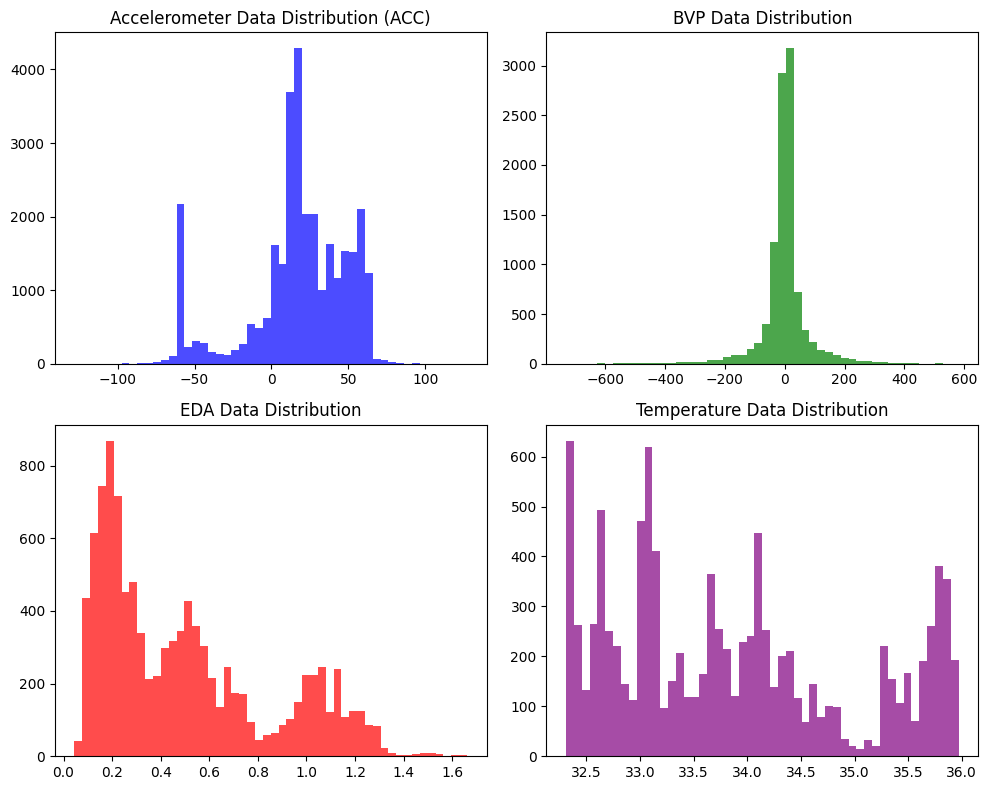

In [10]:
# Plot histograms for one subject's data
subject = 'S2'  # Example subject

# Extract wrist data for the selected subject
wrist_data = balanced_data_all_subjects[subject]['WristData']
acc_data = wrist_data[:, :3]  # First 3 columns are ACC (x, y, z)
bvp_data = wrist_data[:, 3]   # 4th column is BVP
eda_data = wrist_data[:, 4]   # 5th column is EDA
temp_data = wrist_data[:, 5]  # 6th column is TEMP

# Plot histograms
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(acc_data.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Accelerometer Data Distribution (ACC)')

plt.subplot(2, 2, 2)
plt.hist(bvp_data, bins=50, alpha=0.7, color='green')
plt.title('BVP Data Distribution')

plt.subplot(2, 2, 3)
plt.hist(eda_data, bins=50, alpha=0.7, color='red')
plt.title('EDA Data Distribution')

plt.subplot(2, 2, 4)
plt.hist(temp_data, bins=50, alpha=0.7, color='purple')
plt.title('Temperature Data Distribution')

plt.tight_layout()
plt.show()


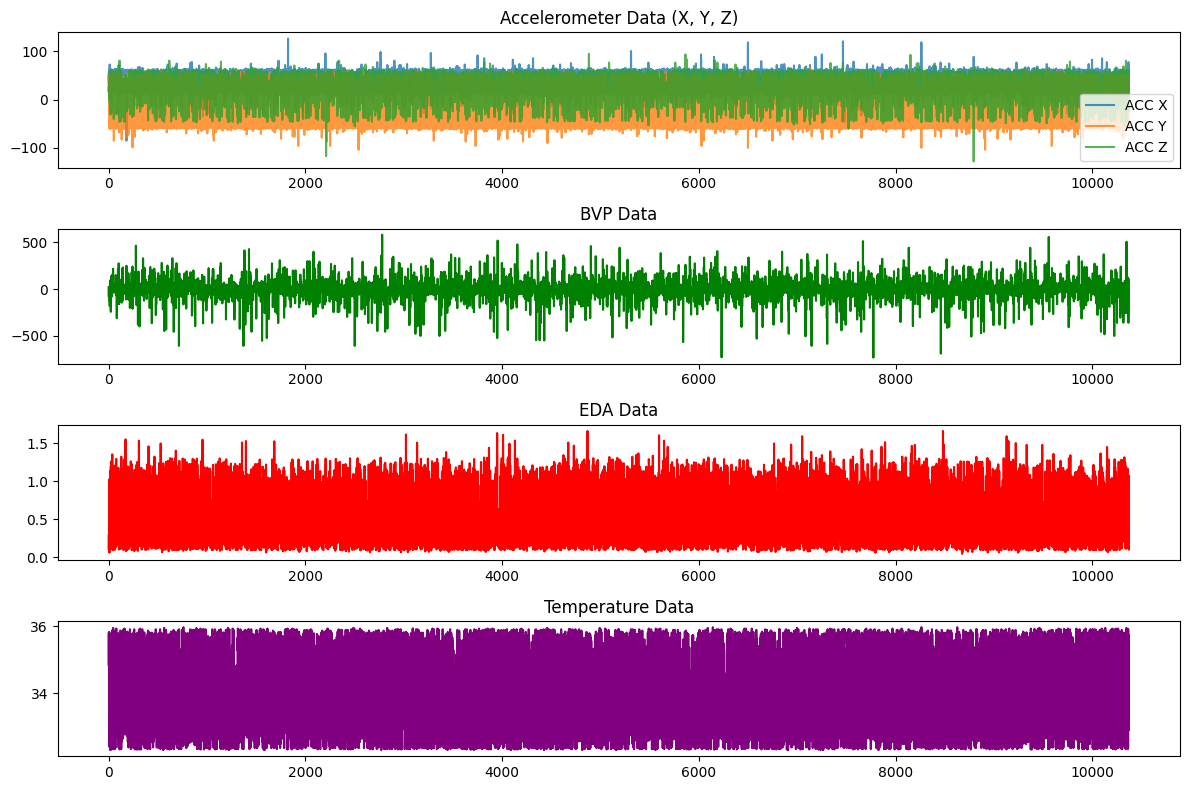

In [11]:
# Plot time series data for one subject's sensors
plt.figure(figsize=(12, 8))

# Plot ACC data
plt.subplot(4, 1, 1)
plt.plot(acc_data[:, 0], label='ACC X', alpha=0.8)
plt.plot(acc_data[:, 1], label='ACC Y', alpha=0.8)
plt.plot(acc_data[:, 2], label='ACC Z', alpha=0.8)
plt.title('Accelerometer Data (X, Y, Z)')
plt.legend()

# Plot BVP data
plt.subplot(4, 1, 2)
plt.plot(bvp_data, color='green')
plt.title('BVP Data')

# Plot EDA data
plt.subplot(4, 1, 3)
plt.plot(eda_data, color='red')
plt.title('EDA Data')

# Plot Temperature data
plt.subplot(4, 1, 4)
plt.plot(temp_data, color='purple')
plt.title('Temperature Data')

plt.tight_layout()
plt.show()


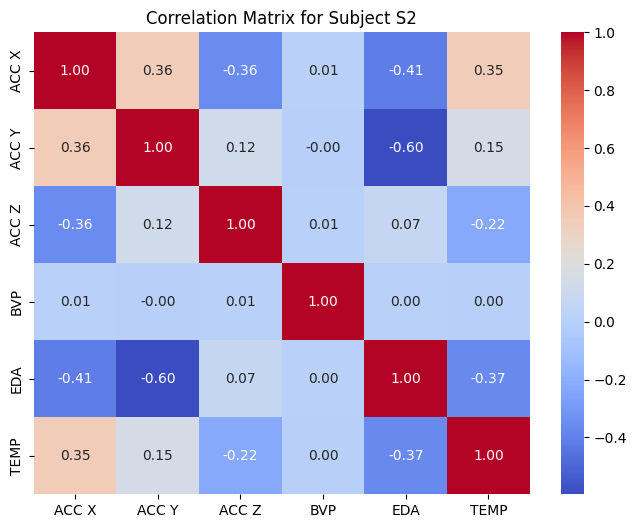

In [12]:
# Compute correlation matrix for one subject's wrist data
corr_matrix = np.corrcoef(wrist_data.T)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            xticklabels=['ACC X', 'ACC Y', 'ACC Z', 'BVP', 'EDA', 'TEMP'],
            yticklabels=['ACC X', 'ACC Y', 'ACC Z', 'BVP', 'EDA', 'TEMP'])
plt.title(f'Correlation Matrix for Subject {subject}')
plt.show()


Combined data shape: (154846, 6)
Combined labels shape: (154846,)
Model: RandomForestClassifier
Accuracy: 0.9942525024216984
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15485
           1       0.99      1.00      0.99     15485

    accuracy                           0.99     30970
   macro avg       0.99      0.99      0.99     30970
weighted avg       0.99      0.99      0.99     30970





c:\Users\JENNIFER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.7921536971262512
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78     15485
           1       0.76      0.86      0.81     15485

    accuracy                           0.79     30970
   macro avg       0.80      0.79      0.79     30970
weighted avg       0.80      0.79      0.79     30970



Model: DecisionTreeClassifier
Accuracy: 0.9909267032612206
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15485
           1       0.99      0.99      0.99     15485

    accuracy                           0.99     30970
   macro avg       0.99      0.99      0.99     30970
weighted avg       0.99      0.99      0.99     30970



Model: LinearDiscriminantAnalysis
Accuracy: 0.603584113658379
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.6

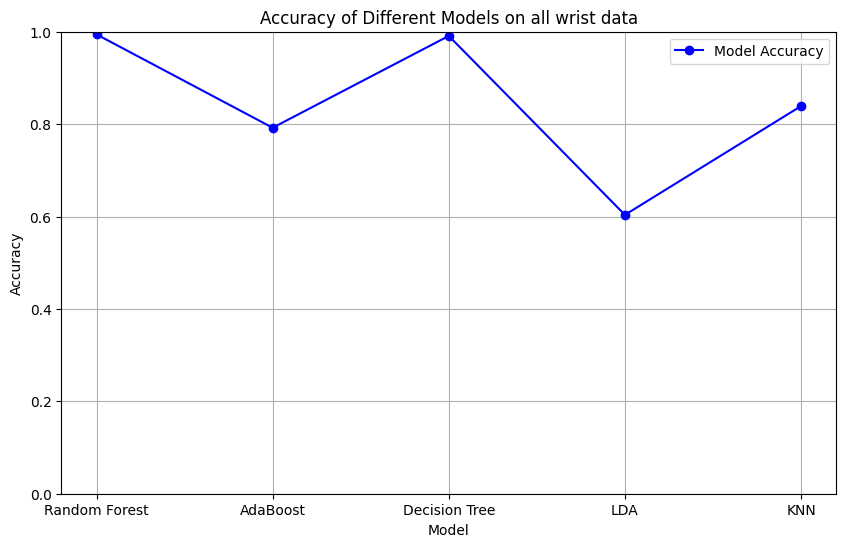

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Combine data and labels from all subjects
combined_data = []
combined_labels = []

for subject, data in balanced_data_all_subjects.items():
    combined_data.append(data['WristData'])
    combined_labels.append(data['Labels'])

# Stack all subjects' data into a single array
combined_data = np.vstack(combined_data)
combined_labels = np.hstack(combined_labels)

# Print the shape of combined data and labels
print(f"Combined data shape: {combined_data.shape}")
print(f"Combined labels shape: {combined_labels.shape}")

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("\n" + "="*60 + "\n")
    
    return accuracy  # Return the accuracy

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
lda_model = LinearDiscriminantAnalysis()
knn_model = KNeighborsClassifier()

# Train and evaluate each model, and store accuracies
models = [rf_model, ada_model, dt_model, lda_model, knn_model]
model_names = ['Random Forest', 'AdaBoost', 'Decision Tree', 'LDA', 'KNN']
accuracies = []

for model in models:
    accuracy = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    accuracies.append(accuracy)

# Plot accuracies as a line graph
plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b', label='Model Accuracy')
plt.title('Accuracy of Different Models on all wrist data')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(True)
plt.legend()
plt.show()


In [14]:

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
print("Random Forest model saved to 'random_forest_model.pkl'")

Random Forest model saved to 'random_forest_model.pkl'


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the model from the .pkl file
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rf_model = pickle.load(file)

print("Random Forest model loaded successfully.")


Random Forest model loaded successfully.


In [16]:
import numpy as np
import random

# Randomly select 5 indices from the test set
random_indices = random.sample(range(len(X_test)), 5)

# Predict using the trained Random Forest model
rf_model.fit(X_train, y_train)  # Ensure the model is trained
predictions = rf_model.predict(X_test)

# Display the selected 5 random data points, their actual labels, and predicted labels
print("Randomly selected 5 data points for manual testing:\n")
for idx in random_indices:
    print(f"Data Point {idx}:")
    print(f"Actual Label: {y_test[idx]}")
    print(f"Predicted Label: {predictions[idx]}")
    print("-" * 40)


Randomly selected 5 data points for manual testing:

Data Point 10147:
Actual Label: 0
Predicted Label: 0
----------------------------------------
Data Point 948:
Actual Label: 0
Predicted Label: 0
----------------------------------------
Data Point 27062:
Actual Label: 0
Predicted Label: 0
----------------------------------------
Data Point 29589:
Actual Label: 0
Predicted Label: 0
----------------------------------------
Data Point 23007:
Actual Label: 1
Predicted Label: 1
----------------------------------------


In [17]:
import numpy as np

# Function to merge wrist data and labels across all subjects
def merge_data_all_subjects(balanced_data_all_subjects, sensor_type):
    # Initialize lists to store merged data and labels
    merged_data = []
    merged_labels = []

    # Loop over all subjects and append their wrist data and labels
    for subject, data in balanced_data_all_subjects.items():
        wrist_data = data['WristData']  # Extract all wrist data
        labels = data['Labels']         # Extract corresponding labels
        
        if sensor_type == 'ACC':
            # Only take ACC columns (3 for x, y, z axes)
            wrist_acc_data = wrist_data[:, :3]
            merged_data.append(wrist_acc_data)
        elif sensor_type == 'BVP':
            wrist_bvp_data = wrist_data[:, 3:4]
            merged_data.append(wrist_bvp_data)
        elif sensor_type == 'EDA':
            wrist_eda_data = wrist_data[:, 4:5]
            merged_data.append(wrist_eda_data)
        elif sensor_type == 'TEMP':
            wrist_temp_data = wrist_data[:, 5:6]
            merged_data.append(wrist_temp_data)

        # Append labels
        merged_labels.append(labels)
    
    # Stack all subject data and labels into single arrays
    merged_data = np.vstack(merged_data)
    merged_labels = np.hstack(merged_labels)
    
    return merged_data, merged_labels

# Merge data for ACC
merged_acc_data, merged_acc_labels = merge_data_all_subjects(balanced_data_all_subjects, sensor_type='ACC')

# Merge data for BVP
merged_bvp_data, merged_bvp_labels = merge_data_all_subjects(balanced_data_all_subjects, sensor_type='BVP')

# Merge data for EDA
merged_eda_data, merged_eda_labels = merge_data_all_subjects(balanced_data_all_subjects, sensor_type='EDA')

# Merge data for TEMP
merged_temp_data, merged_temp_labels = merge_data_all_subjects(balanced_data_all_subjects, sensor_type='TEMP')

# Debugging: Check merged data shapes for all datasets
print(f"Merged ACC data shape: {merged_acc_data.shape}")
print(f"Merged ACC labels shape: {merged_acc_labels.shape}")

print(f"Merged BVP data shape: {merged_bvp_data.shape}")
print(f"Merged BVP labels shape: {merged_bvp_labels.shape}")

print(f"Merged EDA data shape: {merged_eda_data.shape}")
print(f"Merged EDA labels shape: {merged_eda_labels.shape}")

print(f"Merged TEMP data shape: {merged_temp_data.shape}")
print(f"Merged TEMP labels shape: {merged_temp_labels.shape}")


Merged ACC data shape: (154846, 3)
Merged ACC labels shape: (154846,)
Merged BVP data shape: (154846, 1)
Merged BVP labels shape: (154846,)
Merged EDA data shape: (154846, 1)
Merged EDA labels shape: (154846,)
Merged TEMP data shape: (154846, 1)
Merged TEMP labels shape: (154846,)


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(merged_acc_data, merged_acc_labels, test_size=0.3, random_state=42)

# Initialize and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy on ACC data: {accuracy * 100:.2f}%")


Random Forest Accuracy on ACC data: 85.98%


In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(merged_acc_data, merged_acc_labels, test_size=0.3, random_state=42)

# Initialize a dictionary to store models and their accuracies
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'LDA': LDA(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Dictionary to store the accuracy of each model
model_accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the accuracy in the dictionary
    model_accuracies[model_name] = accuracy * 100
    
    # Print the accuracy of the current model
    print(f"{model_name} Accuracy on ACC data: {accuracy * 100:.2f}%")

# Output all model accuracies
print("\nModel Accuracies:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy:.2f}%")


Random Forest Accuracy on ACC data: 85.98%


c:\Users\JENNIFER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy on ACC data: 63.03%
LDA Accuracy on ACC data: 51.99%
Decision Tree Accuracy on ACC data: 85.20%
KNN Accuracy on ACC data: 82.89%
Neural Network Accuracy on ACC data: 69.03%

Model Accuracies:
Random Forest: 85.98%
AdaBoost: 63.03%
LDA: 51.99%
Decision Tree: 85.20%
KNN: 82.89%
Neural Network: 69.03%


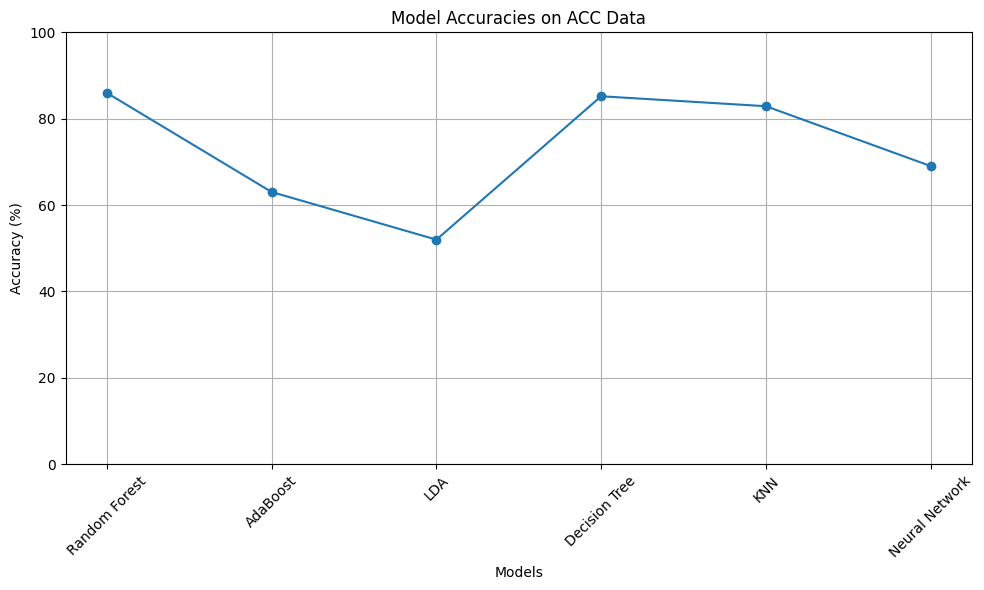

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(model_accuracies.keys(), model_accuracies.values(), marker='o')
plt.title('Model Accuracies on ACC Data')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits to 0-100%
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

In [21]:
import matplotlib.pyplot as plt

# Function to train, evaluate and return model accuracies
def train_and_evaluate(dataset_name, data, labels):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

    # Initialize a dictionary to store models and their accuracies
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'LDA': LDA(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    }

    # Dictionary to store the accuracy of each model
    model_accuracies = {}

    print(f"\nTraining models on {dataset_name} data:")
    
    # Train and evaluate each model
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate the accuracy of the model
        accuracy = accuracy_score(y_test, y_pred)

        # Store the accuracy in the dictionary
        model_accuracies[model_name] = accuracy * 100

        # Print the accuracy of the current model
        print(f"{model_name} Accuracy on {dataset_name} data: {accuracy * 100:.2f}%")
    
    return model_accuracies

In [22]:
# Plotting function to display accuracies
def plot_accuracies(accuracies, dataset_name):
    model_names = list(accuracies.keys())
    accuracy_values = list(accuracies.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, accuracy_values, color='skyblue')
    
    # Adding labels and title
    plt.xlabel('Accuracy (%)')
    plt.title(f'Model Accuracies for {dataset_name} Data')
    
    # Show plot
    plt.tight_layout()
    plt.show()


Training models on BVP data:
Random Forest Accuracy on BVP data: 57.14%


c:\Users\JENNIFER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy on BVP data: 52.01%
LDA Accuracy on BVP data: 49.63%
Decision Tree Accuracy on BVP data: 57.12%
KNN Accuracy on BVP data: 54.94%
Neural Network Accuracy on BVP data: 51.94%


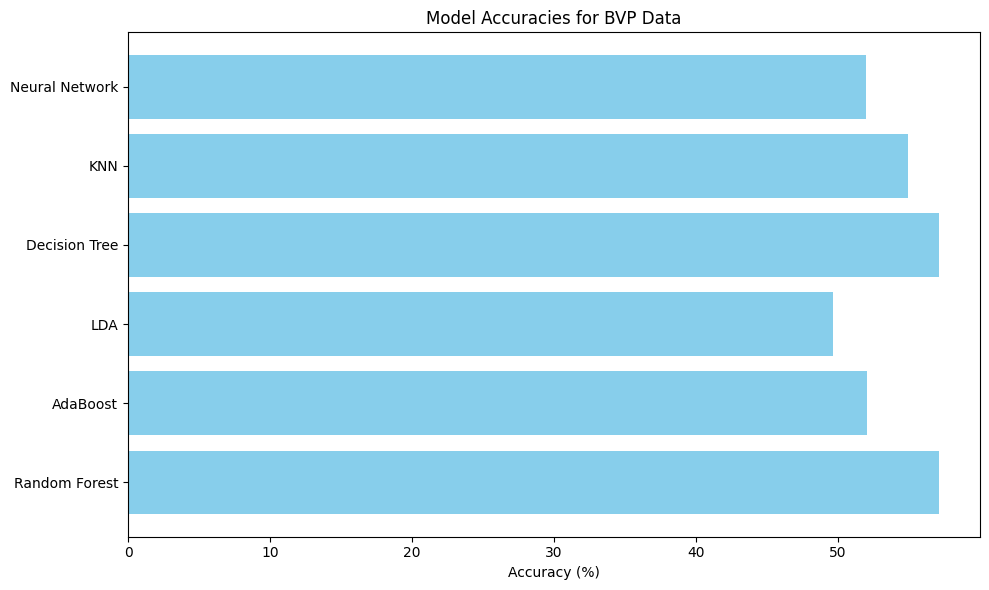


Training models on EDA data:
Random Forest Accuracy on EDA data: 78.39%


c:\Users\JENNIFER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy on EDA data: 68.93%
LDA Accuracy on EDA data: 51.97%
Decision Tree Accuracy on EDA data: 78.20%
KNN Accuracy on EDA data: 75.52%
Neural Network Accuracy on EDA data: 67.53%


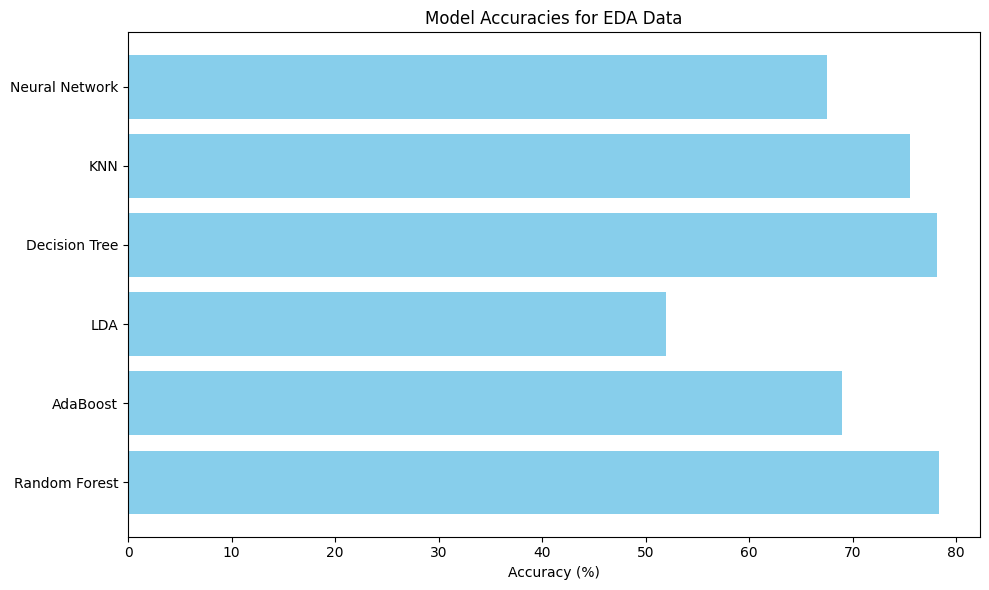


Training models on TEMP data:
Random Forest Accuracy on TEMP data: 71.54%


c:\Users\JENNIFER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy on TEMP data: 70.67%
LDA Accuracy on TEMP data: 58.87%
Decision Tree Accuracy on TEMP data: 71.51%
KNN Accuracy on TEMP data: 68.05%
Neural Network Accuracy on TEMP data: 67.52%


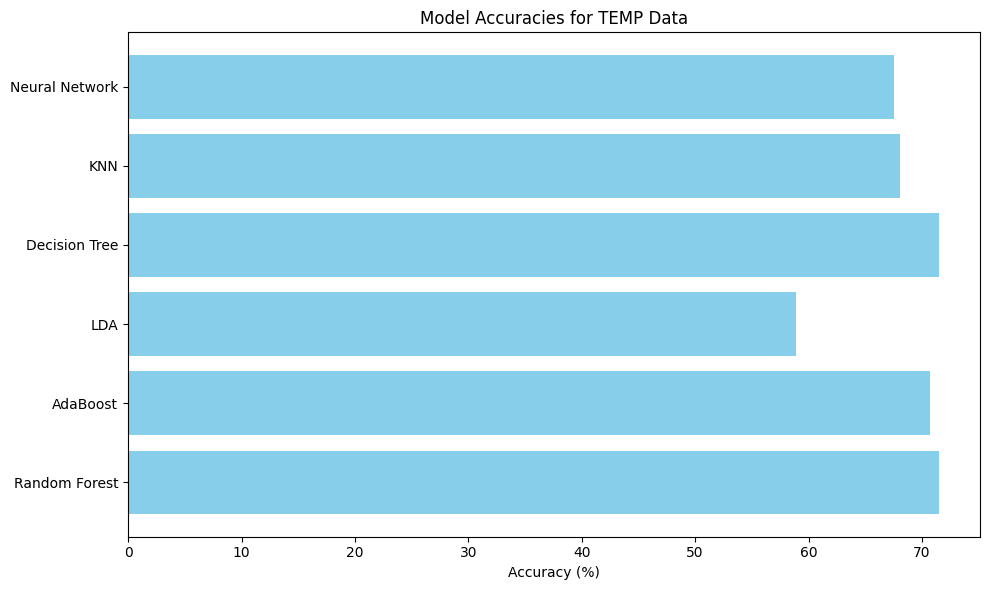

In [23]:
# Train and evaluate for BVP data
bvp_accuracies = train_and_evaluate('BVP', merged_bvp_data, merged_bvp_labels)
plot_accuracies(bvp_accuracies, 'BVP')

# Train and evaluate for EDA data
eda_accuracies = train_and_evaluate('EDA', merged_eda_data, merged_eda_labels)
plot_accuracies(eda_accuracies, 'EDA')

# Train and evaluate for TEMP data
temp_accuracies = train_and_evaluate('TEMP', merged_temp_data, merged_temp_labels)
plot_accuracies(temp_accuracies, 'TEMP')


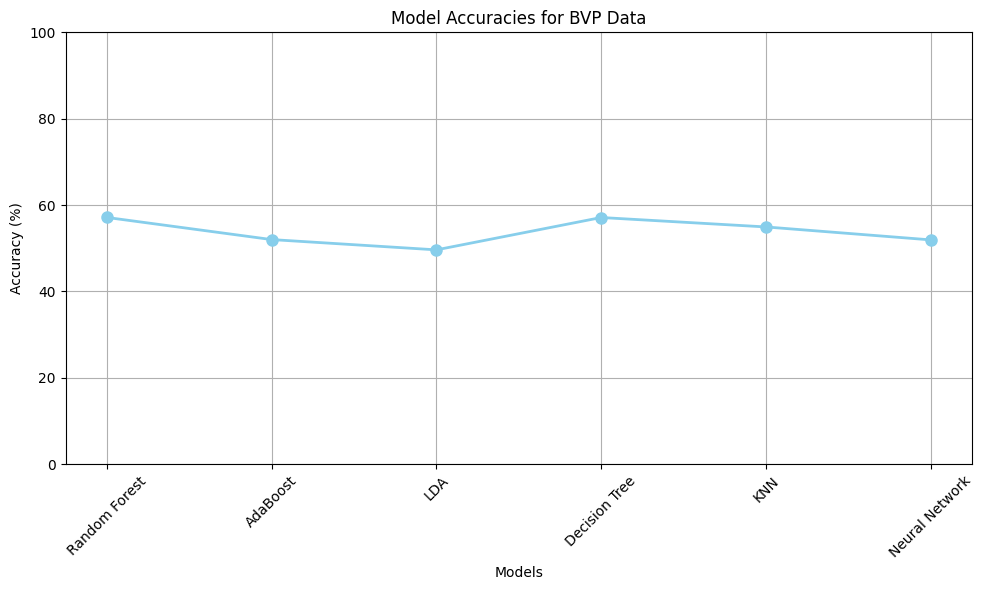

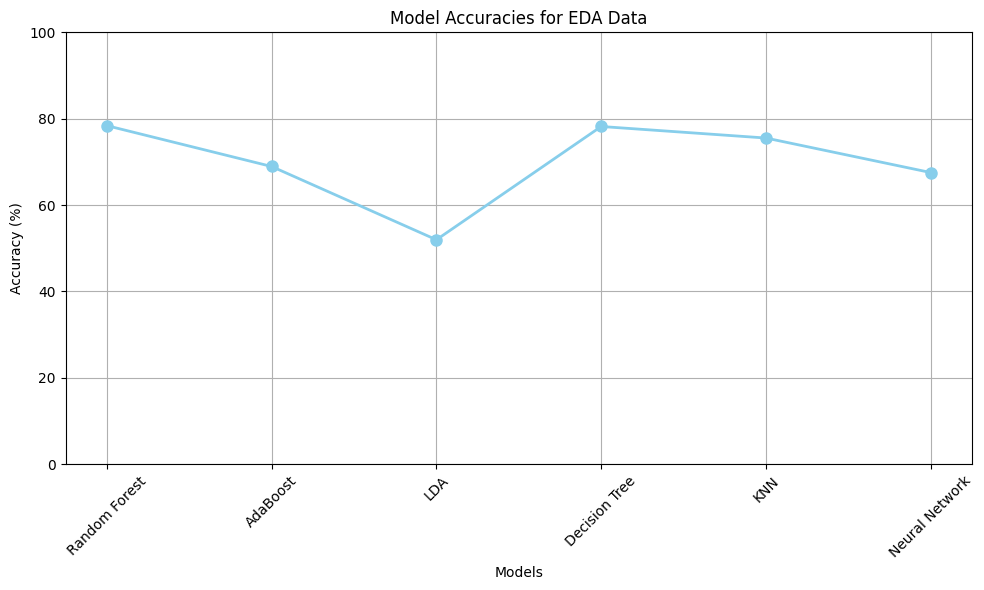

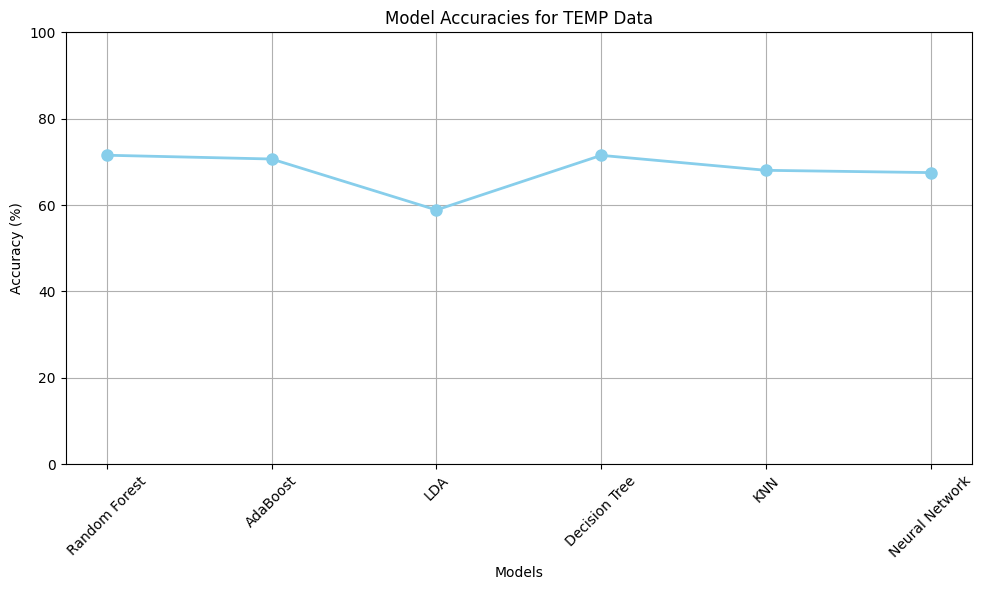

In [24]:
import matplotlib.pyplot as plt

# Plotting function to display accuracies as a line graph
def plot_accuracies(accuracies, dataset_name):
    model_names = list(accuracies.keys())
    accuracy_values = list(accuracies.values())

    # Create a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(model_names, accuracy_values, marker='o', linestyle='-', color='skyblue', linewidth=2, markersize=8)

    # Adding labels and title
    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Model Accuracies for {dataset_name} Data')
    plt.ylim(0, 100)  # Set y-axis limits to 0-100%
    
    # Show grid and layout
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout
    plt.show()

plot_accuracies(bvp_accuracies, 'BVP')

plot_accuracies(eda_accuracies, 'EDA')

plot_accuracies(temp_accuracies, 'TEMP')
